**<h1><center>Disaster Tweets prediction uisng NLP, ML & DL</center></h1>**
<h3><center>Mathan Raj O</center></h3>
<h3><center>11/05/2020</center></h3>

#Table of Contents
<div style='margin-top:20px'>
<font size=3>
 
>1.<a href='#item1'>Introduction</a><br>
>2.<a href='#item2'>Data</a><br>
>3.<a href='item3'>Data Preprocessing</a><br>
>4.<a href='#item4'>Model using DeepLearning</a><br>
>5.<a href='#item5'>Model using ML Algorithsm</a>






</font>
</div>

<a id='item1'></a>

###1.Introduction

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

 The objective is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

<a id='item2'></a>

###2.Data

###Files
train.csv - the training set<br>
test.csv - the test set<br>
sample_submission.csv - a sample submission file in the correct format<br>
###Columns
id - a unique identifier for each tweet<br>
text - the text of the tweet<br>
location - the location the tweet was sent from (may be blank)<br>
keyword - a particular keyword from the tweet (may be blank)<br>
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)<br>

In [2]:
! pip install -q kaggle

from google.colab import files
# Choose the kaggle.json file that you downloaded
files.upload()

# ! mkdir ~/.kaggle
#  Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json


! kaggle datasets list

Saving kaggle.json to kaggle (1).json
ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    2GB  2020-05-02 20:35:01          64602  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          142MB  2020-04-29 22:47:23           8084  
mrmorj/political-advertisements-from-facebook               Political Advertisements from Facebook              237MB  2020-05-05 18:53:51             17  
amanarora/obesity-among-adults-by-country-19752016          Obesity among adults by country, 1975-2016          362KB  2020-05-08 07:40:50             78  
jessemostipak/animal-cross

Downloading the tweets datasets from Kaggle

In [3]:
!kaggle competitions download -w nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 31.6MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 127MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.4MB/s]


###Importing Libraries

In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
df = pd.read_csv('train.csv',usecols=lambda cols:cols not in ['id'])
df_test = pd.read_csv('test.csv')

In [7]:
len(df),len(df_test)

(7613, 3263)

In [8]:
df.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
df.groupby('target').describe()

keyword                          location                        text                                                               
         count unique          top freq    count unique       top freq count unique                                                top freq
target                                                                                                                                     
0         4323    218  body%20bags   40     2884   2142  New York   55  4342   4315  He came to a land which was engulfed in tribal...    4
1         3229    220     wreckage   39     2196   1513       USA   67  3271   3206  11-Year-Old Boy Charged With Manslaughter of T...   10

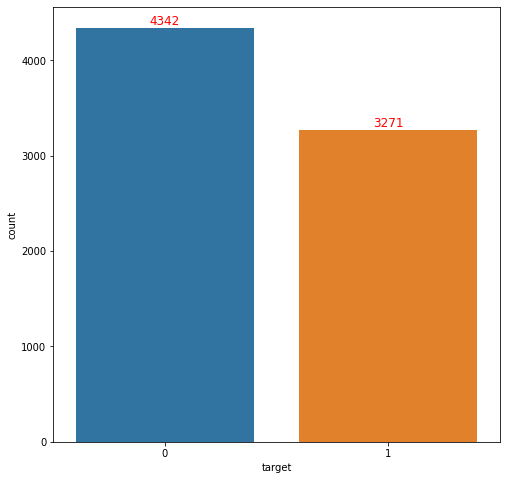

In [11]:
plt.figure(figsize=(8,8))
box = sns.countplot(df.target)
for ax in box.patches:
  box.text(x=(ax.get_x()+ax.get_width()/2),y=ax.get_height(),s=int(ax.get_height()),fontsize=12,
           color='red',ha='center',va='bottom')

There are 4342 non-disaster and 3271 disaster tweets

Calculating the tweet length

In [0]:
df['tweet_len'] = df.text.apply(len)
df_test['tweet_len'] = df_test.text.apply(len)

In [13]:
df.head()

,keyword,location,text,target,tweet_len
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


Checking the trend of tweets against the tweet length

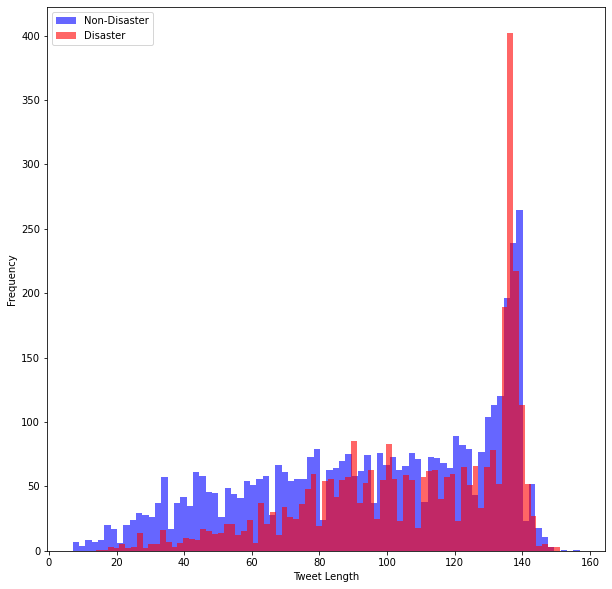

In [14]:
plt.figure(figsize=(10,10))
df[df['target']==0].tweet_len.plot(kind='hist',color='blue',bins=80,alpha=0.6,label='Non-Disaster')
df[df['target']==1].tweet_len.plot(kind='hist',color='red',bins=80,alpha=0.6,label='Disaster')
plt.legend()
plt.xlabel('Tweet Length')
plt.show()

In [15]:
df[df['target']==0].describe()


,target,tweet_len
count,4342.0,4342.000000
mean,0.0,95.706817
std,0.0,35.885924
min,0.0,7.000000
25%,0.0,68.000000
50%,0.0,101.000000
75%,0.0,130.000000
max,0.0,157.000000


In [16]:
df[df['target']==1].describe()

,target,tweet_len
count,3271.0,3271.000000
mean,1.0,108.113421
std,0.0,29.309854
min,1.0,14.000000
25%,1.0,88.000000
50%,1.0,115.000000
75%,1.0,136.000000
max,1.0,151.000000


Checking the tweet with maximum length

In [17]:
df[df['tweet_len']==157].text.iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

In [18]:
df.isnull().sum()

keyword        61
location     2533
text            0
target          0
tweet_len       0
dtype: int64

<a id='item3'></a>

###3.Data Preprocessing

Replacing the nan values

In [0]:
df['keyword'].fillna("",inplace=True)
df_test['keyword'].fillna("",inplace=True)

In [0]:
train_data = df.copy()
test_data = df_test.copy()

In [0]:
train_data = train_data.append(test_data,ignore_index=False)

In [51]:
train_data.head()

,keyword,location,text,target,tweet_len,id
0,,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69,NaN
1,,NaN,Forest fire near La Ronge Sask. Canada,1.0,38,NaN
2,,NaN,All residents asked to 'shelter in place' are ...,1.0,133,NaN
3,,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,NaN
4,,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88,NaN


In [0]:
train_tweet = train_data['keyword']+" "+train_data['text']
train_label = train_data['target']

In [58]:
len(train_data['target'])

10876

In [0]:
ps = PorterStemmer()
wn = WordNetLemmatizer()

Function to clean the text

In [0]:
 # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

In [0]:
import string
def cleanText(message):
  url = re.compile(r'https?://\S+|www\.\S+')#removing the url
  message = url.sub(' ',message)
  html=re.compile(r'<.*?>')#removing html
  message= html.sub(r'',message)
  #removing emojis
  emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
  message =  emoji_pattern.sub(r'', message)
  message = message.lower().strip()
  message = [char for char in message if char not in string.punctuation]
  message = ''.join(message)
  return " ".join([wn.lemmatize(word) for word in message.split() if word not in set(stopwords.words('english'))])


In [54]:
train_tweet.head(2)

0     Our Deeds are the Reason of this #earthquake ...
1               Forest fire near La Ronge Sask. Canada
dtype: object

In [0]:
train_tweet = train_tweet.apply(cleanText)

In [56]:
train_tweet.head(2)

0    deed reason earthquake may allah forgive u
1         forest fire near la ronge sask canada
dtype: object

In [0]:

word_tweet = pd.DataFrame({'tweet':train_tweet,'label':train_label})


###WordCloud to visualize the top words for disaster and non-disaster tweets

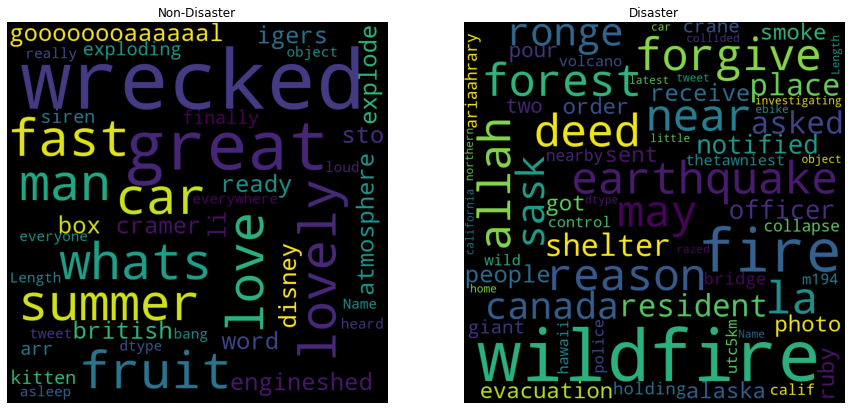

In [65]:

plt.figure(figsize=(15,15))
for i in range(0,2):
      if i ==0:
        title ='Non-Disaster'
      else:
        title = 'Disaster'
      tweet = word_tweet.loc[word_tweet['label']==i,'tweet']
      wordcloud = WordCloud(width=800,height=800,background_color='black',stopwords=set(STOPWORDS),min_font_size=10).generate(str(tweet))
      plt.subplot(1,2,i+1)
      plt.imshow(wordcloud)
      plt.axis('off')
      plt.title(title)

In [0]:
tweet_max_length = max([len(ele) for ele in train_tweet])

In [67]:
tweet_max_length

157

Lets tokenize sentences to list of integers

In [0]:
oov_token = '<OOV>'
max_length = tweet_max_length
padding ='pre'
trunc = 'pre'

In [0]:
# tokenizer = Tokenizer(oov_token = oov_token)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweet.tolist())#create vocabulary
word_index = tokenizer.word_index

# Transforms each text in texts to a sequence of integers.
train_sequence = tokenizer.texts_to_sequences(train_tweet.tolist())
train_padded = pad_sequences(train_sequence,maxlen=max_length,padding=padding,truncating=trunc)

# test_sequence = tokenizer.texts_to_sequences(test_tweet.tolist())
# test_padded = pad_sequences(test_sequence,maxlen=max_length,padding=padding,truncating=trunc)


In [0]:
word_index.get('earthquake')

160

In [0]:
train_tweet[0],train_padded[0]

('deed reason earthquake may allah forgive u',
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    

Model

In [0]:
# corpus_size = len(word_index)+1
# embedding_dim =128

In [0]:

# train_padded = np.array(train_padded)
# train_label = np.array(train_label)
# test_padded = np.array(test_padded)

In [0]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip 



--2020-05-11 14:24:10--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2020-05-11 14:24:10--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2020-05-11 14:24:11--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [0]:
!unzip glove.42B.300d.zip  -d '/content/drive/My Drive/Colab Notebooks/glove.42B.300d'

Archive:  glove.42B.300d.zip
  inflating: /content/drive/My Drive/Colab Notebooks/glove.42B.300d/glove.42B.300d.txt  


In [0]:
#Glove Embedding
embedding_dict={}
with open('/content/drive/My Drive/Colab Notebooks/glove.42B.300d/glove.42B.300d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()


In [71]:
len(embedding_dict)

1917494

In [0]:
def build_vocab(tweet):
  tweets = tweet.apply(lambda x:x.split()).values
  vocab={}
  # print(tweets)
  for tweet in tweets:
    for word in tweet:
      try:
        vocab[word]+=1
      except KeyError:
        vocab[word]=1
  return vocab



In [0]:
def check_embedding(tweet_vocab,embedding):
  vocab = build_vocab(tweet_vocab)
  # del vocab['<OOV>']
  covered_words={}
  oov_words={}
  covered_count=0
  oov_count=0
  for word in vocab:
    try:
      covered_words[word] = embedding[word]
      covered_count+=vocab[word]
    except KeyError:
      oov_words[word] = vocab[word]
      oov_count+=vocab[word]
  print(f'Words covered by glove embeddings : {covered_count}')
  print(f'Words not covered by glove embeddings : {oov_count}')
  print(f'Percentage of words covered by glove embeddings: {(covered_count/(covered_count+oov_count))*100}%')
  return covered_words,oov_words


In [74]:
covered, oov = check_embedding(train_tweet,embedding_dict)

Words covered by glove embeddings : 103363
Words not covered by glove embeddings : 10154
Percentage of words covered by glove embeddings: 91.05508426050723%


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
target_acc = .90
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs['accuracy'] and logs['val_accuracy']>=target_acc:
            self.model.stop_training=True
            print('Reached {} Model Accuracy'.format(target_acc))

In [0]:
embed_size = 300 # how big is each word vector
maxlen = 20 # max number of words in a comment to use
max_features = 20000

In [76]:
len(word_index),len(covered)

(21086, 14600)

In [0]:
num_words = min(max_features, len(word_index)) + 1
embedding_dim = 300
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))
# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = covered.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.initializers import Constant

In [80]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
    
    
])
model.compile(optimizer=RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           6000300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2

In [0]:
X_train = train_padded[:7613]
X_test = train_padded[7613:]
y_train = train_label[:7613]


In [83]:
type(train_padded)

numpy.ndarray

In [90]:
EPOCHS = 20
lrReduce = ReduceLROnPlateau(factor=0.1,patience=1,verbose=1,min_delta=0.00001,monitor='accuracy')
history = model.fit(X_train,y_train,batch_size=128,epochs=EPOCHS,callbacks=[lrReduce])

Epoch 1/20
60/60 [==============================] - 9s 151ms/step - loss: 0.5042 - accuracy: 0.7616 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 9s 147ms/step - loss: 0.4442 - accuracy: 0.8011 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 9s 147ms/step - loss: 0.4173 - accuracy: 0.8151 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 9s 147ms/step - loss: 0.3985 - accuracy: 0.8194 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 9s 147ms/step - loss: 0.3832 - accuracy: 0.8313 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 9s 146ms/step - loss: 0.3713 - accuracy: 0.8363 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 9s 146ms/step - loss: 0.3507 - accuracy: 0.8450 - lr: 0.0010
Epoch 8/20
60/60 [==============================] - 9s 146ms/step - loss: 0.3401 - accuracy: 0.8534 - lr: 0.0010
Epoch 9/20
60/60 [==============================] - 9s 147ms/step - loss: 0.3197 - accuracy: 0.8

In [0]:
y_pred = model.predict_classes(test_padded)

In [0]:
y_pred = model.predict(test_padded)

In [0]:
y_pred[:9]

array([[8.4335893e-01],
       [6.5053397e-01],
       [9.9932420e-01],
       [9.9647433e-01],
       [9.9748683e-01],
       [2.5979412e-01],
       [2.1668947e-04],
       [3.8839266e-02],
       [3.0484607e-02]], dtype=float32)

In [0]:
submission = pd.read_csv("sample_submission.csv")


In [0]:
submission['target'] = y_pred

In [0]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [0]:
submission.to_csv('submission.csv',index=False)

In [0]:
!kaggle competitions submit nlp-getting-started -f submission.csv -m "My submission"

100% 22.2k/22.2k [00:02<00:00, 8.68kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets

<a id='item5'></a>

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier


In [0]:
def trainTestSplit(train,label):
    return train_test_split(train,label,test_size=0.2,random_state=42)


In [0]:

clfs = [MultinomialNB(), LogisticRegression(), RidgeClassifier(),RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()]
# clfs = [RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()]





In [0]:
def doModel(x,y):
  X_train,X_valid, y_train,y_valid = trainTestSplit(x,y)
  print(X_train.shape)
  # X_train = X_train.reshape(X_train.shape[0],100)
  # X_valid = X_valid.reshape(X_valid.shape[0],100)
  print(X_train.shape)
  for clf in clfs:
      clf.fit(X_train,y_train)
      train_score = clf.score(X_train,y_train)
      valid_score = clf.score(X_valid,y_valid)
      print(clf.__class__.__name__+'Training Score is {} and Validation Score is {}'.format(train_score,valid_score))


In [0]:
ml_train = train_tweet[:7613]

In [0]:
train_corpus = ml_train.tolist()


In [100]:
cv = CountVectorizer(max_features=8000,ngram_range=(1,3))
cv_x = cv.fit_transform(train_corpus)
doModel(cv_x,y_train)

(6090, 8000)
(6090, 8000)
MultinomialNBTraining Score is 0.8543513957307061 and Validation Score is 0.7997373604727511
LogisticRegressionTraining Score is 0.9251231527093596 and Validation Score is 0.7925147734734077
RidgeClassifierTraining Score is 0.9566502463054187 and Validation Score is 0.762967826657912
RandomForestClassifierTraining Score is 0.9860426929392446 and Validation Score is 0.7715036112934996
AdaBoostClassifierTraining Score is 0.768144499178982 and Validation Score is 0.7491792514773473
GradientBoostingClassifierTraining Score is 0.7722495894909688 and Validation Score is 0.7386736703873933


In [102]:
tf = TfidfVectorizer(max_features=6000,ngram_range=(1,3))
tf_x = tf.fit_transform(train_corpus).toarray()
doModel(tf_x,y_train)



(6090, 6000)
(6090, 6000)
MultinomialNBTraining Score is 0.8492610837438423 and Validation Score is 0.7997373604727511
LogisticRegressionTraining Score is 0.865024630541872 and Validation Score is 0.7951411687458962
RidgeClassifierTraining Score is 0.90311986863711 and Validation Score is 0.7905449770190414
RandomForestClassifierTraining Score is 0.9853858784893268 and Validation Score is 0.7846355876559422
AdaBoostClassifierTraining Score is 0.7683087027914615 and Validation Score is 0.7458962573867367
GradientBoostingClassifierTraining Score is 0.7719211822660098 and Validation Score is 0.7413000656598818


In [0]:
from gensim.models import Word2Vec,word2vec


Create the list of words

In [0]:
list_words=[]
for sent in train_corpus:
  list_words.append(sent.split())

In [0]:
len(list_words)

7613

Building a COW model

In [0]:
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

In [0]:
print("Training model....")
model = word2vec.Word2Vec(list_words,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

Training model....


In [0]:
model = Word2Vec(size=100, window=5, min_count=30, sg=0)

In [0]:
model.build_vocab(list_words)

In [0]:
model.corpus_count

7613

In [0]:

model.train(list_words,total_examples=model.corpus_count,epochs=100)

(3907703, 9675400)

In [0]:
features= []
for i in range(len(list_words)):
    t2 = list_words[i]
    z = np.zeros((1,300))
    k=0
    index2word_set = set(model.wv.index2word)
    for j in range(len(t2)):
        try:
          if t2[j] in index2word_set:
              z = np.add(z,model[t2[j]])
              k= k+1
        except KeyError:
            continue
    features.append(np.nan_to_num(z/k))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [0]:
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [0]:
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [0]:
    
trainDataVecs = getAvgFeatureVecs(list_words, model, 300)

Review 0 of 7613
Review 1000 of 7613
Review 2000 of 7613


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Review 3000 of 7613
Review 4000 of 7613
Review 5000 of 7613
Review 6000 of 7613
Review 7000 of 7613


In [0]:
np.isnan(trainDataVecs).sum()


3000

In [0]:
train_corpus[0]

'deed reason earthquake may allah forgive u'

In [0]:
model['may']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.2492356e+00,  1.5110336e-01, -1.0372769e+00,  1.2827884e+00,
        1.1006128e+00,  3.6341971e-01,  1.6746952e-01,  3.9335859e-01,
       -5.5464578e-01,  5.1854298e-02,  1.3268600e+00,  2.2280963e-02,
       -5.3962839e-01, -1.0034665e+00,  5.9694964e-01,  1.0230263e+00,
        1.1363341e+00, -6.3833153e-01,  4.1062217e-02, -9.7495830e-01,
       -2.0249788e-01, -1.1710902e-01, -6.3567775e-01,  7.7382213e-01,
        8.3618712e-01,  8.1777394e-01, -3.4881315e-01, -9.1492224e-01,
       -1.1361679e+00, -2.6904345e-01, -1.6666001e+00,  2.4831219e+00,
        3.1912285e-01, -5.1683956e-01,  2.6017613e+00,  1.7729881e+00,
       -3.7076131e-02, -9.5552832e-01, -1.7929164e+00, -6.8492311e-01,
       -6.3257420e-01,  9.1208124e-01, -1.5551491e+00,  9.3012500e-01,
        1.2795894e+00, -5.7743347e-01,  1.4376429e-01,  5.1170148e-02,
        1.7259054e+00, -6.9620293e-01,  5.7481050e-02,  5.5937999e-01,
        8.5697725e-02, -1.1963296e+00,  9.6775317e-01,  8.8948548e-02,
      

In [0]:
model[model.wv.vocab][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 9.13347721e-01,  6.92272902e-01, -1.18461585e+00,  1.67225853e-01,
       -6.58412129e-02,  1.00496376e+00, -4.99042302e-01,  1.10549235e+00,
        6.65859997e-01, -3.76301706e-01, -1.61402488e+00,  2.62574941e-01,
       -5.47550142e-01, -1.23878944e+00, -8.25451910e-01, -7.62926135e-03,
       -1.34581700e-01, -1.75120264e-01, -6.78238630e-01, -8.94919336e-01,
        2.49637276e-01, -1.78716823e-01, -1.21175401e-01,  4.23309624e-01,
       -1.25400460e+00, -1.67151105e+00, -1.49744809e+00, -3.28331202e-01,
        1.29015756e+00, -4.09096599e-01,  1.34545537e-02,  4.46761638e-01,
        6.31060719e-01, -2.49769852e-01,  2.66065635e-03,  1.72706604e-01,
       -7.86496401e-01,  8.42571780e-02, -1.87795401e-01, -1.80582210e-01,
       -1.28392565e+00,  6.12952709e-01, -1.44047272e+00,  4.59541194e-02,
        1.54839182e+00, -1.12181747e+00, -1.22319020e-01, -1.40300500e+00,
        1.06769204e+00, -1.68531373e-01, -3.19991797e-01,  1.08409250e+00,
        7.63882816e-01,  

In [0]:
features_arr  = np.array(features)


In [0]:

np.isnan(features_arr).sum()

0

In [0]:
features_arr.shape

(7613, 1, 300)

In [0]:
feature_reshape = features_arr.reshape(features_arr.shape[0],300)

In [0]:
feature_reshape.shape

(7613, 300)

In [0]:
doModel(feature_reshape,train_label)

(6090, 300)
(6090, 300)
RandomForestClassifierTraining Score is 0.9738916256157636 and Validation Score is 0.7518056467498359
AdaBoostClassifierTraining Score is 0.764367816091954 and Validation Score is 0.7229152987524623
GradientBoostingClassifierTraining Score is 0.8178981937602627 and Validation Score is 0.7458962573867367
